In [12]:
import torch
from pnpflow.utils import load_cfg_from_cfg_file, merge_cfg_from_list
from pnpflow.utils import define_model, load_model
from main import DataLoaders
from matplotlib import pyplot as plt
from pnpflow.degradations import *
import pnpflow.utils as utils
import numpy as np

plt.rcParams.update({
    "text.usetex": True,          # enable LaTeX rendering
    "font.family": "serif",       # serif font (Computer Modern)
    "font.serif": ["Computer Modern Roman"],
})


In [13]:
cfg = load_cfg_from_cfg_file('./' + 'config/main_config.yaml')
dataset = 'celeba'
method = 'ot'

dataset_config = cfg.root + \
    'config/dataset_config/{}.yaml'.format(
        dataset)
cfg.update(load_cfg_from_cfg_file(dataset_config))

method_config_file = cfg.root + \
    'config/method_config/{}.yaml'.format(
        cfg.method)
cfg.update(load_cfg_from_cfg_file(method_config_file))

# for all keys in the method config file, create a dictionary {key: value} in the cfg object cfg.dict_cfg_method
method_cfg = load_cfg_from_cfg_file(method_config_file)
cfg.dict_cfg_method = {}
for key in method_cfg.keys():
    cfg.dict_cfg_method[key] = cfg[key]

In [14]:
device = "cuda:3"
cfg.device = device
print(cfg)
(model, state) = define_model(cfg)

alpha: 1.0
batch_size_ip: 4
batch_size_train: 16
compute_lipschitz: False
compute_memory: False
compute_metrics: False
compute_time: False
dataset: afhq_cat
device: cuda:3
dict_cfg_method: {'steps_pnp': 100, 'lr_pnp': 1.0, 'gamma_style': 'alpha_1_minus_t', 'num_samples': 5, 'alpha': 1.0}
dim_image: 128
eval: True
eval_split: test
finetune: False
gamma_style: alpha_1_minus_t
lipschitz_constraint: None
lr: 0.0001
lr_pnp: 1.0
max_batch: 1
method: pnp_flow
model: ot
noise_type: gaussian
num_channels: 3
num_epoch: 100
num_samples: 5
problem: superresolution
root: ./
save_results: True
seed: 0
steps_pnp: 100
train: False


In [15]:
batch_size_ip = 1
batch_size = 1
data_loaders = DataLoaders(dataset, batch_size, batch_size_ip).load_data()

model_path = 'model/{}/{}/model_final.pt'.format(dataset, 'ot')
load_model('ot', model, state, download=False,
    checkpoint_path=model_path, dataset=None,  device=device)
model.eval()
model = model.to(device)


/home/pourya/PnP-Flow1/pnpflow/utils.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [16]:
problem = 'denoising'
noise_type = 'gaussian'
dim_image = 128
num_channels = 3

if problem == "denoising":
    if noise_type == 'laplace':
        sigma_noise = 0.3
    elif noise_type == 'gaussian':
        sigma_noise = 0.2
    degradation = Denoising()

elif problem == "inpainting":
    if noise_type == 'laplace':
        sigma_noise = 0.3
    elif noise_type == 'gaussian':
        sigma_noise = 0.05
    if dim_image == 128:
        half_size_mask = 20
    elif dim_image == 256:
        half_size_mask = 40
    degradation = BoxInpainting(half_size_mask)

elif problem == "paintbrush_inpainting":
    if noise_type == 'laplace':
        sigma_noise = 0.3
    elif noise_type == 'gaussian':
        sigma_noise = 0.05
    degradation = PaintbrushInpainting()

elif problem == "random_inpainting":
    if noise_type == 'laplace':
        sigma_noise = 0.3
    elif noise_type == 'gaussian':
        sigma_noise = 0.01
    p = 0.7
    degradation = RandomInpainting(p)

elif problem == "superresolution":
    if dim_image == 128:
        print('Superresolution with scale factor 2')
        sf = 2
    elif dim_image == 256:
        print('Superresolution with scale factor 4')
        sf = 4
    if noise_type == 'laplace':
        sigma_noise = 0.3

    elif noise_type == 'gaussian':
        sigma_noise = 0.05
    degradation = Superresolution(sf, dim_image)

elif problem == "deblurring":
    if dim_image == 128:
        sigma_blur = 1.0
    elif dim_image == 256:
        sigma_blur = 3.0

    if noise_type == 'laplace':
        sigma_noise = 0.3
    elif noise_type == 'gaussian':
        sigma_noise = 0.05
    kernel_size = 61
    degradation = GaussianDeblurring(
        sigma_blur, kernel_size, "fft", num_channels, dim_image, device)
    
def model_forward(x, t):
    return model(x, t)


def interpolation_step(x, t):
    return t * x + torch.randn_like(x) * (1 - t)

def denoiser(self, x, t):
    v = self.model_forward(x, t)
    return x + (1 - t.view(-1, 1, 1, 1)) * v


def BtB(x, H, Ht, lam, R):    
    BtBD =(Ht(H(x)/R)) + x / lam
    return BtBD

def cg(b, x0=None, lam=1, max_iter=100, eps=1e-5, H=lambda x: x, Ht=lambda x: x, dims=(1, 2, 3), R=1.0):
    
    A = lambda x: BtB(x, H, Ht, lam, R)
    if x0 is None:
        x0 = torch.zeros_like(b, device=b.device, dtype=b.dtype)
    
    x = x0.clone() 
    r = b - A(x)

    p = r.clone()
    r_norm = r_norm_old = (r ** 2).sum(dim=dims, keepdim=True)  

    with torch.no_grad():
        for i in range(max_iter):

            BTBp = A(p)
            alpha = r_norm / ((p * BTBp).sum(dim=dims, keepdim=True))

            x = x + alpha * p
            r_norm_old = r_norm.clone()
            r = r - alpha * BTBp

            r_norm = (r ** 2).sum(dim=dims, keepdim=True) 
            if r_norm.sqrt().all() < eps:
                break
            beta = r_norm / (r_norm_old)
            p = r + beta * p

    return x, i


steps = 20
H = degradation.H
Ht = degradation.H_adj
delta = 1.0 / steps
num_samples = 1
mask1 = torch.zeros((1, 3, dim_image, dim_image), device=device)
mask1[:, :, int(dim_image/4):int(3*dim_image/4), int(dim_image/4):int(3*dim_image/4)] = 1.0

R = sigma_noise ** 2 * mask1 * 16 + sigma_noise ** 2  * (1 - mask1)
for image, i in data_loaders['test']:
    gt = image.to(device)
    y = H(gt) + sigma_noise * 4 *torch.randn_like(H(gt), device=device) * mask1 + sigma_noise  * torch.randn_like(H(gt), device=device) * (1 - mask1)

    x_avg = torch.zeros_like(gt, device=device)
    for _ in range(num_samples):    
        x =  torch.randn_like(gt, device=device)
        ones = torch.ones(len(x), device=device) 
        for count, iteration in enumerate(range(int(steps))):
            
            t = delta * iteration    
            
            sigma_r = (1 - t) / np.sqrt(t**2 + (1-t)**2)
            
            x_hat_1 = x + (1 - t) * model_forward(x, ones * t)

            
            lam = sigma_r ** 2
            b = Ht(y/R) + x_hat_1 / lam
            x_star, _ = cg(b, x_hat_1, lam, max_iter=50, eps=1e-5, H=H, Ht=Ht, R=R)

        
            z0 =  torch.randn_like(x, device=device)
            
            estimated_iso_cov = 1 - t - delta

            x = (t + delta) * x_star + estimated_iso_cov * z0
        x_avg += x
    x = x_avg / num_samples  
    break

clean_img = gt.detach().clone()
noisy_img = y.detach().clone()
restored_img = x.detach().clone()
psnr_rec = utils.compute_psnr_func(clean_img, restored_img, cfg)
ssim_rec = utils.compute_ssim_func(clean_img, restored_img, cfg)
lpips_rec = utils.compute_lpips_func(clean_img, restored_img, cfg)

print('PSNR Rec: ', psnr_rec, ' SSIM Rec: ', ssim_rec, ' LPIPS Rec: ', lpips_rec)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/pourya/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pourya/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pourya/miniconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
PSNR Rec:  28.562311816693988  SSIM Rec:  0.7849877638822402  LPIPS Rec:  0.04400084167718887


/home/pourya/miniconda3/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_locati

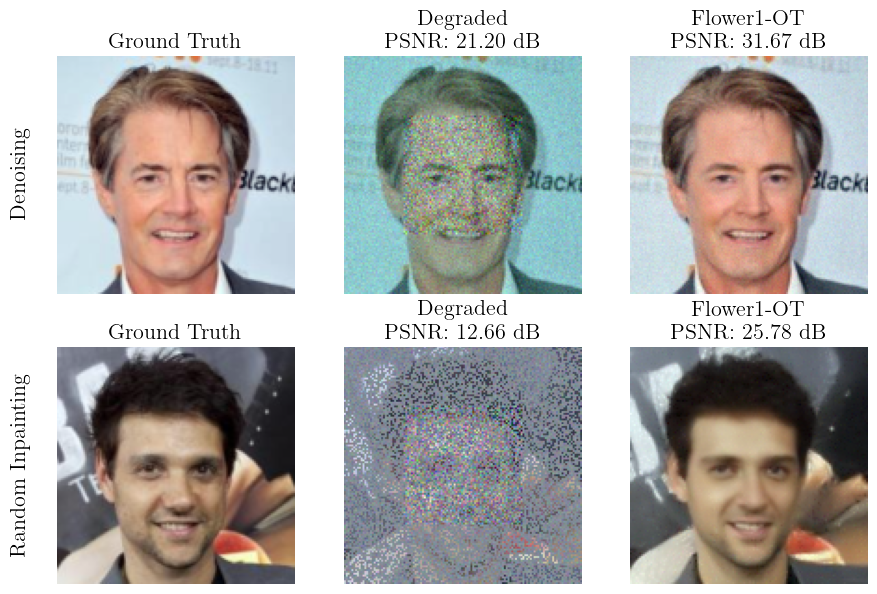

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) helpers for plotting
# ============================================================

def normalize_0_1(t):
    """Per-image min-max normalization to [0,1]."""
    if t.ndim == 4:  # B C H W
        t = t[0]
    t = t.detach().cpu()
    if t.ndim == 3:
        t_min = t.amin(dim=(1, 2), keepdim=True)
        t_max = t.amax(dim=(1, 2), keepdim=True)
    else:
        t_min = t.min()
        t_max = t.max()
    t_norm = (t - t_min) / (t_max - t_min + 1e-8)
    return t_norm

def tensor_to_image(t):
    """Convert BCHW/CHW tensor to numpy image in [0,1]."""
    t = normalize_0_1(t)
    if t.ndim == 3 and t.shape[0] == 1:
        img = t[0].numpy()
    elif t.ndim == 3:
        img = t.permute(1, 2, 0).numpy()
    else:
        img = t.numpy()
    return img

def make_task_label(problem, noise_type):
    return problem.replace("_", " ").title() 

def plot_flower_results(rows):
    """
    rows: list of dicts with keys:
        'label', 'gt', 'degraded', 'restored',
        'psnr_degraded', 'psnr_restored'
    """
    n_rows = len(rows)
    fig, axes = plt.subplots(
        n_rows, 4,
        figsize=(9, 3 * n_rows),
        gridspec_kw={'width_ratios': [0.01, 1, 1, 1]}
    )
    if n_rows == 1:
        axes = np.expand_dims(axes, 0)

    fs = 16
    for i, row in enumerate(rows):
        ax_label, ax_gt, ax_deg, ax_rec = axes[i]

        # rotated task label
        ax_label.axis("off")
        ax_label.text(
            0.5, 0.5, row["label"],
            rotation=90,
            ha="center", va="center", fontsize=fs
        )

        gt_img   = tensor_to_image(row["gt"])
        deg_img  = tensor_to_image(row["degraded"])
        rec_img  = tensor_to_image(row["restored"])

        for ax, img in zip([ax_gt, ax_deg, ax_rec],
                           [gt_img, deg_img, rec_img]):
            ax.imshow(img, cmap="gray" if img.ndim == 2 else None)
            ax.axis("off")

        ax_gt.set_title("Ground Truth", fontsize=fs)
        ax_deg.set_title(
            f"Degraded\nPSNR: {row['psnr_degraded']:.2f} dB",
            fontsize=fs
        )
        ax_rec.set_title(
            f"Flower1-OT \nPSNR: {row['psnr_restored']:.2f} dB",
            fontsize=fs
        )

    plt.tight_layout()
    plt.show()
    return fig

# ============================================================
# 2) your reconstruction code wrapped for one (task, image_id)
# ============================================================

def build_degradation(problem, noise_type, dim_image, num_channels, device):
    if problem == "denoising":
        degradation = Denoising()

    elif problem == "inpainting":
        half_size_mask = 20 if dim_image == 128 else 40
        degradation = BoxInpainting(half_size_mask)

    elif problem == "paintbrush_inpainting":
        degradation = PaintbrushInpainting()

    elif problem == "random_inpainting":
        p = 0.7
        degradation = RandomInpainting(p)

    elif problem == "superresolution":
        if dim_image == 128:
            sf = 2
        elif dim_image == 256:
            sf = 4
        degradation = Superresolution(sf, dim_image)

    elif problem == "deblurring":
        sigma_blur = 1.0 if dim_image == 128 else 3.0
        kernel_size = 61
        degradation = GaussianDeblurring(
            sigma_blur, kernel_size, "fft", num_channels, dim_image, device
        )
    else:
        raise ValueError(f"Unknown problem: {problem}")

    return degradation, None

def BtB(x, H, Ht, lam, R):
    return Ht(H(x) / R) + x / lam

def cg(b, x0=None, lam=1, max_iter=100, eps=1e-5,
       H=lambda x: x, Ht=lambda x: x, dims=(1,2,3), R=1.0):

    A = lambda x: BtB(x, H, Ht, lam, R)
    if x0 is None:
        x0 = torch.zeros_like(b, device=b.device, dtype=b.dtype)

    x = x0.clone()
    r = b - A(x)
    p = r.clone()
    r_norm = r_norm_old = (r ** 2).sum(dim=dims, keepdim=True)

    with torch.no_grad():
        for i in range(max_iter):
            Ap = A(p)
            alpha = r_norm / ((p * Ap).sum(dim=dims, keepdim=True))
            x = x + alpha * p
            r_norm_old = r_norm.clone()
            r = r - alpha * Ap
            r_norm = (r ** 2).sum(dim=dims, keepdim=True)
            if r_norm.sqrt().all() < eps:
                break
            beta = r_norm / r_norm_old
            p = r + beta * p
    return x, i

def model_forward(x, t):
    return model(x, t)

def run_single_image(problem, image_id,
                     noise_type="gaussian",
                     dim_image=128,
                     num_channels=3,
                     steps=20,
                     num_samples=1):

    degradation, _ = build_degradation(
        problem, noise_type, dim_image, num_channels, device
    )
    sigma_noise = 0.1
    H, Ht = degradation.H, degradation.H_adj
    delta = 1.0 / steps

    # pick the image you want by index
    img, _ = data_loaders["test"].dataset[image_id]
    gt = img.unsqueeze(0).to(device)  # 1,C,H,W

    # noise structure (same as your code)
    mask1 = torch.zeros((1, 3, dim_image, dim_image), device=device)
    mask1[:, :, dim_image//4:3*dim_image//4,
               dim_image//4:3*dim_image//4] = 1.0

    R = sigma_noise**2 * mask1 * 9 + sigma_noise**2 * (1 - mask1)

    y = H(gt) \
        + sigma_noise * 3 * torch.randn_like(H(gt), device=device) * mask1 \
        + sigma_noise     * torch.randn_like(H(gt), device=device) * (1 - mask1)

    x_avg = torch.zeros_like(gt, device=device)

    for _ in range(num_samples):
        x = torch.randn_like(gt, device=device)
        ones = torch.ones(len(x), device=device)

        for it in range(int(steps)):
            t = delta * it
            sigma_r = (1 - t) / np.sqrt(t**2 + (1 - t)**2)

            x_hat_1 = x + (1 - t) * model_forward(x, ones * t)

            lam = sigma_r ** 2
            b = Ht(y / R) + x_hat_1 / lam
            x_star, _ = cg(b, x_hat_1, lam,
                           max_iter=50, eps=1e-5,
                           H=H, Ht=Ht, R=R)

            z0 = torch.randn_like(x, device=device)
            estimated_iso_cov = 1 - t - delta
            x = (t + delta) * x_star + estimated_iso_cov * z0

        x_avg += x

    x_rec = x_avg / num_samples

    clean_img   = gt.detach().clone()
    noisy_img   = y.detach().clone()
    restored_img = x_rec.detach().clone()

    psnr_noisy  = utils.compute_psnr_func(clean_img, noisy_img, cfg)
    psnr_rec    = utils.compute_psnr_func(clean_img, restored_img, cfg)

    row = dict(
        label=make_task_label(problem, noise_type),
        gt=clean_img,
        degraded=noisy_img,
        restored=restored_img,
        psnr_degraded=psnr_noisy,
        psnr_restored=psnr_rec,
    )
    return row

# ============================================================
# 3) choose what you want in each row
# ============================================================

experiments = [
    dict(problem="denoising",              image_id=43, noise_type="gaussian"),
    dict(problem="random_inpainting", image_id=115, noise_type="gaussian"),
]

rows = [run_single_image(**exp) for exp in experiments]

fig = plot_flower_results(rows)
fig.savefig("flower_non_iso_results.png", bbox_inches="tight")
fig.show()

